In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised


In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/drive/My Drive/datasets'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


In [ ]:
import time

tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056  # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/My Drive/datasets'

for subdir, dirs, files in os.walk(folder_path):
    for file in files:

        # Fetch the sample rate.
        _, sr = librosa.load(path=os.path.join(subdir, file), sr=None)
        # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(subdir, file))
        # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom=0)
        # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
        # Trim silence from the beginning and the end.
        xt, index = librosa.effects.trim(normal_x, top_db=30)

        # Check if the length of xt is greater than total_length
        if len(xt) > total_length:
            xt = xt[:total_length]
        else:
            # Pad for duration equalization.
            padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
            # Noise reduction.
            final_x = nr.reduce_noise(padded_x, sr=sr)  # updated 03/03/22

            # Features extraction
            f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)  # Energy - Root Mean Square
            f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True)  # ZCR
            f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)  # MFCC

            # Emotion extraction from the different databases
            if find_emotion_T(file) != "-1":  # TESS database validation
                name = find_emotion_T(file)
            else:  # RAVDESS database validation
                name = file[6:8]

            # Filling the data lists
            rms.append(f1.T)  # Transpose to match the (batch, timesteps, feature) format
            zcr.append(f2.T)  # Transpose to match the (batch, timesteps, feature) format
            mfcc.append(f3.T)  # Transpose to match the (batch, timesteps, feature) format
            emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")


Running time: 33.5178 minutes


In [7]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')

f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (8492, 1, 339)
RMS shape: (8492, 1, 339)
MFCCs shape: (8492, 13, 339)


In [13]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=1)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)


In [14]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist()
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[0], [2], [1], [2], [1], [2], [4], [2], [0], [1], [3], [2], [4], [3], [0], [1], [1], [2], [3], [1], [2], [3], [3], [0], [2], [3], [4], [3], [1], [1], [3], [4], [6], [7], [6], [7], [4], [7], [7], [4], [5], [4], [5], [6], [5], [5], [7], [5], [6], [7], [5], [7], [6], [4], [6], [5], [6], [6], [5], [7], [0], [1], [1], [3], [1], [1], [3], [3], [3], [4], [1], [3], [0], [2], [2], [2], [4], [0], [1], [3], [2], [2], [0], [2], [3], [1], [2], [4], [1], [2], [3], [5], [6], [7], [7], [5], [4], [5], [7], [5], [6], [5], [7], [5], [5], [7], [6], [4], [6], [6], [6], [7], [4], [5], [4], [4], [6], [6], [7], [7], [0], [0], [1], [2], [1], [1], [2], [0], [2], [1], [3], [2], [2], [1], [3], [1], [2], [2], [1], [0], [1], [3], [4], [3], [3], [3], [4], [2], [3], [3], [4], [7], [6], [5], [7], [5], [4], [6], [6], [5], [5], [4], [5], [7], [6], [7], [4], [5], [7], [7], [5], [4], [6], [6], [7], [6], [6], [5], [4], [7], [2], [0], [3], [2], [0], [1], [0], [2], [3], [3], [1], [2], [1], [2], [1], [3], [1], [1], [3], [2]

In [15]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [16]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [17]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(7430, 15, 339)
(739, 15, 339)
(323, 15, 339)


In [18]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[0], [5], [2], [7], [2], [0], [2], [6], [7], [5], [2], [5], [6], [4], [3], [5], [4], [6], [4], [0], [0], [5], [0], [7], [5], [4], [0], [6], [3], [6], [4], [6], [2], [6], [2], [3], [7], [7], [6], [7], [5], [5], [2], [3], [3], [1], [0], [3], [5], [3], [0], [6], [4], [5], [5], [4], [5], [0], [0], [3], [6], [6], [6], [7], [7], [7], [6], [2], [2], [6], [4], [4], [2], [7], [4], [5], [2], [6], [4], [6], [3], [7], [5], [6], [5], [6], [5], [5], [1], [7], [6], [4], [3], [0], [3], [3], [4], [7], [7], [6], [2], [6], [6], [6], [4], [6], [2], [0], [3], [0], [4], [3], [1], [7], [0], [0], [4], [3], [1], [7], [4], [1], [6], [4], [0], [6], [3], [7], [1], [7], [6], [4], [3], [7], [3], [3], [5], [3], [2], [2], [0], [0], [4], [6], [7], [7], [7], [5], [3], [3], [7], [2], [0], [2], [0], [1], [5], [6], [5], [2], [5], [0], [7], [3], [3], [0], [0], [5], [0], [6], [3], [5], [7], [7], [3], [7], [3], [5], [7], [3], [5], [5], [0], [6], [2], [6], [6], [7], [6], [7], [4], [7], [3], [2], [7], [6], [2

In [19]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

In [20]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=340, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            103424    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 136968 (535.03 KB)
Trainable params: 136968 (535.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/340
324/324 [==============================] - 17s 38ms/step - loss: 1.1711 - categorical_accuracy: 0.5952 - val_loss: 0.8413 - val_categorical_accuracy: 0.6996 - lr: 0.0010
Epoch 2/340
  1/324 [..............................] - ETA: 14s - loss: 0.5250 - categorical_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


324/324 [==============================] - 9s 28ms/step - loss: 0.6894 - categorical_accuracy: 0.7615 - val_loss: 0.6770 - val_categorical_accuracy: 0.7578 - lr: 0.0010
Epoch 3/340
324/324 [==============================] - 12s 38ms/step - loss: 0.5738 - categorical_accuracy: 0.8036 - val_loss: 0.5932 - val_categorical_accuracy: 0.7848 - lr: 0.0010
Epoch 4/340
324/324 [==============================] - 10s 30ms/step - loss: 0.4943 - categorical_accuracy: 0.8307 - val_loss: 0.5333 - val_categorical_accuracy: 0.8281 - lr: 0.0010
Epoch 5/340
324/324 [==============================] - 12s 36ms/step - loss: 0.4325 - categorical_accuracy: 0.8555 - val_loss: 0.5224 - val_categorical_accuracy: 0.8390 - lr: 0.0010
Epoch 6/340
324/324 [==============================] - 11s 35ms/step - loss: 0.3611 - categorical_accuracy: 0.8773 - val_loss: 0.4766 - val_categorical_accuracy: 0.8363 - lr: 0.0010
Epoch 7/340
324/324 [==============================] - 9s 28ms/step - loss: 0.3238 - categorical_accura

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

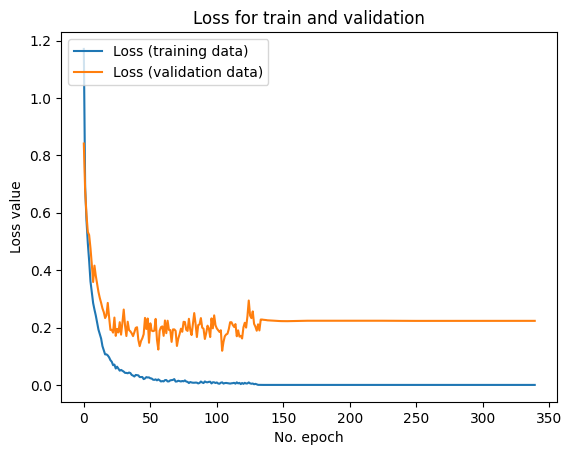

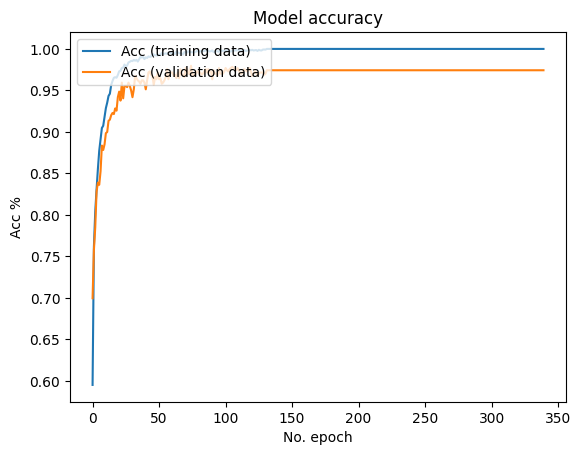

In [22]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [23]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

24/24 - 0s - loss: 0.1852 - categorical_accuracy: 0.9797 - 233ms/epoch - 10ms/step


In [37]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")


Validation set predicted emotions accuracy:
neutral : 0.9785
calm : 0.7222
happy : 1.0000
sad : 1.0000
angry : 1.0000
fearful : 0.9808
disgust : 0.9907
surprised : 1.0000


In [38]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


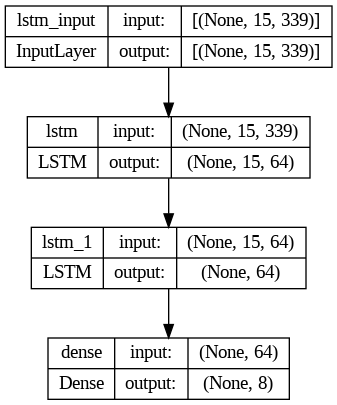

In [39]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [40]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [41]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

11/11 - 3s - loss: 0.1831 - categorical_accuracy: 0.9628 - 3s/epoch - 230ms/step


11/11 [==============================] - 2s 19ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

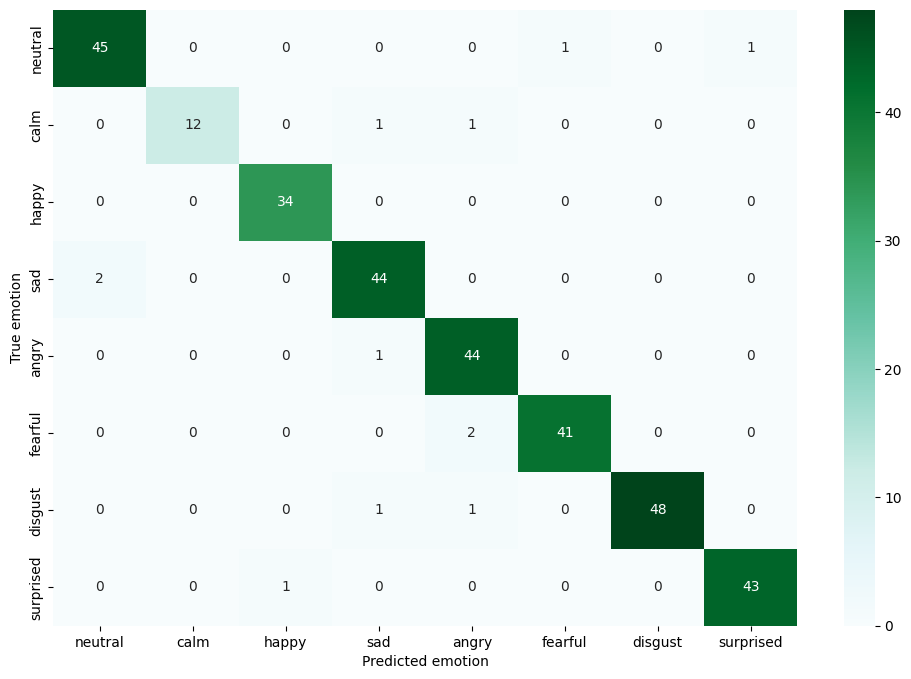

In [42]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [43]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.9574
calm : 0.8571
happy : 1.0000
sad : 0.9565
angry : 0.9778
fearful : 0.9535
disgust : 0.9600
surprised : 0.9773
